In [1]:
import gamspy as gp
import gamspy.math as gpm
from gamspy import Sum, Card

import sys
import numpy as np
import pandas as pd

In [4]:
m = gp.Container(load_from="digits.gdx")

# Sets
p, headr = m.getSymbols(["Dim1", "Dim2"])

# Parameters
[data] = m.getSymbols(["Data"])
display(data.pivot())

train = gp.Set(m,'train',domain=p) 
test = gp.Set(m,'test',domain=p) 
j = gp.Set(m,'j',domain=headr,description='index of independent variables')
y = gp.Parameter(m,'y',domain=p) 

j.setRecords([str(x) for x in range(1, 65)])
# y.setRecords(records=[x for x in range(1, 65)])
# Determine j and y here

y[p].where[data[p, '65'] + data[p, '66'] + data[p, '67'] + data[p, '68'] + data[p, '74'] == 1] = gp.Number(1)
y[p].where[data[p, '65'] + data[p, '66'] + data[p, '67'] + data[p, '68'] + data[p, '74'] == 0] = gp.Number(-1)

train[p] = gp.Number(1).where[p.val <= 3500]
test[p] = ~train[p]

,1,2,3,4,5,6,7,8,9,10,...,65,66,67,68,69,70,71,72,73,74
1,-0.0,-0.33954,0.34365,0.98892,0.98735,0.78802,-0.11683,-0.12673,-0.02604,-0.64171,...,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2,-0.0,-0.33954,-1.16098,-2.79747,-0.38360,1.32295,1.65503,-0.12673,-0.02604,-0.64171,...,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
3,-0.0,-0.33954,-0.30119,-0.90428,-2.66852,-0.99509,-0.41214,-0.12673,-0.02604,-0.64171,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0
4,-0.0,-0.33954,0.34365,0.51562,0.53037,1.32295,0.47379,-0.12673,-0.02604,-0.64171,...,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0
5,-0.0,-0.33954,-1.16098,-2.56082,0.07339,-0.63847,-0.41214,-0.12673,-0.02604,-0.64171,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4492,-0.0,-0.33954,-0.73108,0.27897,0.98735,1.32295,0.76910,-0.12673,-0.02604,-0.64171,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0
4493,-0.0,-0.33954,-0.08625,0.04232,-1.29757,-0.99509,-0.41214,-0.12673,-0.02604,-0.64171,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0
4494,-0.0,-0.33954,-0.73108,-0.66763,0.98735,0.07477,-0.41214,-0.12673,-0.02604,-0.31836,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0
4495,-0.0,1.95952,1.41838,0.75227,0.98735,0.78802,-0.11683,-0.12673,-0.02604,0.32833,...,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [5]:
C = gp.Parameter(m,'C',records=1)

# Write SVM model here
i = m.addSet('i', domain=p)
i[p] = train[p]

delta = m.addVariable('delta','positive',domain=p)
w = m.addVariable('w','free',domain=j)
gamma = m.addVariable('gamma','free')

cons = m.addEquation('cons', domain=p)
cons[i] = y[i]*(Sum(j, data[i,j]*w[j]) + gamma) + delta[i] >= 1

svm = m.addModel('svm',
    equations=m.getEquations(),
    problem=gp.Problem.QCP,
    sense=gp.Sense.MIN,
    objective=C*Sum(i, delta[i]) + 0.5*Sum(j, gpm.sqr(w[j]))
)

err = m.addSet('err',domain=p)
svm.solve(solver='mosek')

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,689.382602201402,3501,3566,QCP,MOSEK,0.321


Following cell sets up the folds for cross-validation.  The set train is split into k subsets (or folds) that are randomly selected subsets of train.

We then use cross-validation to determine the CV error for each "trial" value of $C$.

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

trialvals = [0.001, 0.01, 0.1, 1, 5, 10, 100]

# do CV here
cv = []
for C_val in trialvals:
    C[:] = C_val
    err[p] = False
    for train_index, tune_index in kf.split(train.records):
        i.setRecords(train.records.loc[train_index])
        svm.solve(solver='mosek',output=None)
        i.setRecords(train.records.loc[tune_index])
        err[i].where[(Sum(j, data[i,j]*w.l[j]) - gamma.l) * y[i] < 0] = True
    cv.append(len(err.records)/len(train.records))

idx = 0
for value in cv:
    print(f"The error rate on trial value {trialvals[idx]} is: {round(value * 100, 2)}%")
    idx += 1

print("The best trial value for C is 0.01!")



The error rate on trial value 0.001 is: 9.89
The error rate on trial value 0.01 is: 8.26
The error rate on trial value 0.1 is: 8.49
The error rate on trial value 1 is: 8.77
The error rate on trial value 5 is: 8.74
The error rate on trial value 10 is: 8.71
The error rate on trial value 100 is: 8.74


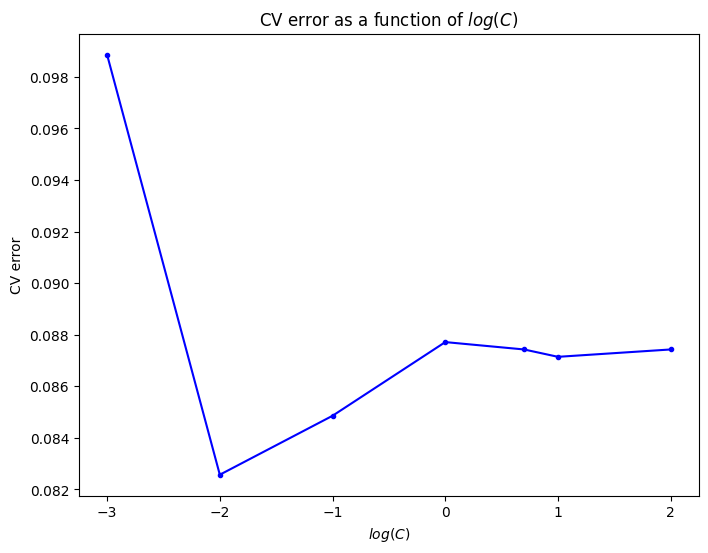

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))
ax.set_title("CV error as a function of $log(C)$")
ax.set_xlabel("$log(C)$")
ax.set_ylabel("CV error")
ax.plot(np.log10(trialvals),cv,"b.-");

Finally, we set the value of $C$ to the best one (from CV) and rerun the model using all the data, then generate predictions in the test set

In [20]:
# Evaluation at best value of C
C.setRecords(0.01)

pred = m.addParameter('pred',domain=p,description='prediction')
errorrate = m.addParameter('errorrate')

i[p] = train[p]
svm.solve()

pred[test] = gpm.sign(Sum(j, data[test,j]*w.l[j]) - gamma.l)

errorrate[:] = Sum(test, (pred[test] * y[test] < 0)) / len(test.records)


print(f"The Error Rate on unseen data is {round(errorrate.toValue() * 100, 2)}%")

The Error Rate on unseen data is 8.03%
